In [51]:
from dragonFunctions import *
from pathlib import Path
import os
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import statkit
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pylab
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.calibration import calibration_curve
import seaborn as sns
from typing import List, Tuple
from sklearn.base import BaseEstimator
sns.set_theme()

base_directory = Path('..') / 'Data'

base_directory.mkdir(parents=True, exist_ok=True)

# Data Loading

In [52]:
patient_df = pd.read_csv('/Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/patient_df.csv')

# Data Preprocessing

## Keep Only First Admission

In [53]:
patient_df = patient_df.drop_duplicates(subset='SUBJECT_ID', keep='first')

## Define 30-Day Mortality Boolean

In [54]:
patient_df['DOD'] = pd.to_datetime(patient_df['DOD'])
patient_df['ADMITTIME'] = pd.to_datetime(patient_df['ADMITTIME'])

# define 30-days mortality column 
patient_df['DIFF_DAYS'] = (patient_df['DOD'] - patient_df['ADMITTIME']).dt.days
patient_df['MORTALITY'] = patient_df['DIFF_DAYS'].apply(lambda x: 0 if x>30 else 1)

In [55]:
patient_df['MORTALITY'].value_counts()

1    3281
0    1274
Name: MORTALITY, dtype: int64

## Group Ethnicities

In [56]:
def consolidate_ethnicity(ethnicity):
    ethnicity = ethnicity.upper()  # Convert to uppercase for consistency
    
    # Grouping logic
    if 'WHITE' in ethnicity:
        return 'WHITE'
    elif 'BLACK' in ethnicity or 'AFRICAN AMERICAN' in ethnicity:
        return 'BLACK OR AFRICAN AMERICAN'
    elif 'ASIAN' in ethnicity:
        return 'ASIAN'
    elif 'HISPANIC' in ethnicity or 'LATINO' in ethnicity:
        return 'HISPANIC OR LATINO'
    elif 'AMERICAN INDIAN' in ethnicity or 'ALASKA NATIVE' in ethnicity:
        return 'AMERICAN INDIAN OR ALASKA NATIVE'
    elif 'NATIVE HAWAIIAN' in ethnicity or 'PACIFIC ISLANDER' in ethnicity:
        return 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'MIDDLE EASTERN'
    elif ('UNKNOWN' in ethnicity or 'NOT SPECIFIED' in ethnicity or
          'DECLINED TO ANSWER' in ethnicity or 'UNABLE TO OBTAIN' in ethnicity):
        return 'UNKNOWN/NOT SPECIFIED/DECLINED'
    else:
        return 'OTHER'
    

# Apply the consolidation to create a new column
patient_df['ETHNICITY_CONSOLIDATED'] = patient_df['ETHNICITY'].apply(consolidate_ethnicity)

print(patient_df['ETHNICITY_CONSOLIDATED'].value_counts())

WHITE                                        3360
BLACK OR AFRICAN AMERICAN                     436
UNKNOWN/NOT SPECIFIED/DECLINED                340
ASIAN                                         148
HISPANIC OR LATINO                            144
OTHER                                         117
AMERICAN INDIAN OR ALASKA NATIVE                4
MIDDLE EASTERN                                  4
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       2
Name: ETHNICITY_CONSOLIDATED, dtype: int64


## Drop Extraneous Columns

Unnecessary patient data and identifiers will be dropped from the `patient_df`

In [57]:
columns_to_drop = ['Unnamed: 0', 'SUBJECT_ID', 'DOB', 'DOD','HOSPITAL_EXPIRE_FLAG', 'HADM_ID', 'ADMITTIME', 'DIFF_DAYS', 'DISCHTIME', 'ETHNICITY','TEMP_MEAN_C', 'CHLORIDE_MAX_VAL', 'CREATININE_MAX_VAL', 'LACTATE_MAX_VAL', 'PLATELET_MAX_VAL','POTASSIUM_MAX_VAL']
existing_columns_to_drop = [col for col in columns_to_drop if col in patient_df.columns]

# Drop the columns
patient_df = patient_df.drop(columns=existing_columns_to_drop)

patient_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4555 entries, 0 to 5175
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GENDER                  4555 non-null   object 
 1   ADMISSION_TYPE          4555 non-null   object 
 2   AGE_AT_ADMISSION        4555 non-null   int64  
 3   LOS                     4555 non-null   int64  
 4   LOS_ICU_MEAN            4554 non-null   float64
 5   WEIGHT_MEAN             4323 non-null   float64
 6   HEARTRATE_MEAN          4550 non-null   float64
 7   SBP_MEAN                4551 non-null   float64
 8   DBP_MEAN                4551 non-null   float64
 9   MAP_MEAN                4551 non-null   float64
 10  RR_MEAN                 4551 non-null   float64
 11  TEMP_MIN_C              4543 non-null   float64
 12  TEMP_MAX_C              4543 non-null   float64
 13  OXYGEN_SAT_MEAN         4547 non-null   float64
 14  DIABETES                4555 non-null   

## Encoding Categorical Features

In [58]:
# Identify categorical columns
categorical_cols = patient_df.select_dtypes(include=['object', 'category']).columns.tolist()

df = pd.get_dummies(patient_df, columns=categorical_cols, drop_first=True)

## Handle `null` Values

In [59]:
null_counts = df.isnull().sum()

null_counts_df = null_counts.reset_index()
null_counts_df.columns = ['Column Name', 'Null Count']

total_rows = len(df)
null_counts = df.isnull().sum()
null_percent = (null_counts / total_rows) * 100

null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage (%)': null_percent
})

null_summary

,Null Count,Null Percentage (%)
AGE_AT_ADMISSION,0,0.000000
LOS,0,0.000000
LOS_ICU_MEAN,1,0.021954
WEIGHT_MEAN,232,5.093304
HEARTRATE_MEAN,5,0.109769
SBP_MEAN,4,0.087816
DBP_MEAN,4,0.087816
MAP_MEAN,4,0.087816
RR_MEAN,4,0.087816
TEMP_MIN_C,12,0.263447


In [60]:
numerical_cols = df.select_dtypes(include=['number']).columns
mean_values = df[numerical_cols].mean()

df[numerical_cols] = df[numerical_cols].fillna(mean_values)
null_counts = df[numerical_cols].isnull().sum()

## Outlier Handling

We handle outliers using two functions: 

1. `preprocess_outliers(df, threshold=3)`
2. `compare_summary_stats(summary_before, summary_after)`



```python
def preprocess_outliers(df, threshold=3):
    """
    Detects and caps outliers in non-binary numerical columns of the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Number of standard deviations to define outliers.
    
    Returns:
    - df_capped (pd.DataFrame): DataFrame with outliers capped.
    - summary_before (pd.DataFrame): Summary statistics before capping.
    - summary_after (pd.DataFrame): Summary statistics after capping.
    - capped_summary (pd.DataFrame): Count of capped values per column.
    """
```

```python
def compare_summary_stats(summary_before, summary_after):
    """
    Compares summary statistics before and after outlier handling.
    
    Parameters:
    - summary_before (pd.DataFrame): Summary statistics before handling outliers.
    - summary_after (pd.DataFrame): Summary statistics after handling outliers.
    
    Returns:
    - comparison_table (pd.DataFrame): Table showing before, after, and changes.
    """
```

In [61]:
def save_dataframe(df, filename, base_dir):
    file_path = base_dir / filename
    df.to_csv(file_path, index=False)
    print(f"{filename} saved successfully at: {file_path.resolve()}")

df_capped, summary_before, summary_after, capped_summary, binary_numerical_cols = preprocess_outliers(df, threshold=2)

comparison_table = compare_summary_stats(summary_before, summary_after, capped_summary)

save_dataframe(comparison_table, 'Outlier_Report.csv', base_directory)
save_dataframe(df_capped, 'patient_df_capped.csv', base_directory)

Outlier_Report.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/Outlier_Report.csv
patient_df_capped.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/patient_df_capped.csv


# EDA

We get the mean and p-values of the numberical features using the following functions: `mean_confidence_interval` and `get_stats`

```python

def mean_confidence_interval(data, confidence=0.95):
    """
    Calculate the mean and confidence interval for a list of numbers.
    """

def get_stats(df, group_col='MORTALITY', confidence=0.95):
    """
    Analyze numerical features in the dataframe, aggregating by the specified group column.
    
    Parameters:
    - df: pandas DataFrame
    - group_col: column name to group by (binary: 0 or 1)
    - confidence: confidence level for intervals
    
    Returns:
    - result_df: pandas DataFrame with mean (CI) for each group and p-value
    """
```

In [62]:
eda_df = get_stats(df_capped)
eda_df.sort_values('p-value')

save_dataframe(eda_df, 'Feature_Means_Report.csv', base_directory)

Feature_Means_Report.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/Feature_Means_Report.csv


# Models

### Train Test Split and Scaling

In [63]:
# Define features and target
X = df_capped.drop(['MORTALITY'], axis=1)
y = df_capped['MORTALITY']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numerical features for scaling
# Assuming all features are numerical; if not, adjust accordingly
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

## XGBoost

The code blocks below were used to show the development of the XGBoost model.

### Initial XGBoost Model Iteration

In [64]:
# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100  # Set the number of trees explicitly
)

# Train the model without early stopping
xgb_clf.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=True
)

# Make predictions
y_pred_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
y_pred = xgb_clf.predict(X_test_scaled)

# Evaluate the model
print("=== Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}\n")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.55344
[1]	validation_0-logloss:0.53118
[2]	validation_0-logloss:0.51855
[3]	validation_0-logloss:0.51490
[4]	validation_0-logloss:0.51177
[5]	validation_0-logloss:0.50622
[6]	validation_0-logloss:0.50257
[7]	validation_0-logloss:0.50056
[8]	validation_0-logloss:0.50057
[9]	validation_0-logloss:0.50000
[10]	validation_0-logloss:0.49875
[11]	validation_0-logloss:0.49810
[12]	validation_0-logloss:0.50331
[13]	validation_0-logloss:0.50371
[14]	validation_0-logloss:0.50479
[15]	validation_0-logloss:0.51037
[16]	validation_0-logloss:0.51000
[17]	validation_0-logloss:0.51167
[18]	validation_0-logloss:0.51573
[19]	validation_0-logloss:0.51723
[20]	validation_0-logloss:0.51787
[21]	validation_0-logloss:0.51878
[22]	validation_0-logloss:0.51839
[23]	validation_0-logloss:0.51946
[24]	validation_0-logloss:0.52046
[25]	validation_0-logloss:0.52026
[26]	validation_0-logloss:0.52414
[27]	validation_0-logloss:0.52649
[28]	validation_0-logloss:0.52760
[29]	validation_0-loglos

### Model Tuning with GridSearch
Below is the code used to find the paramters used for the XGB model

In [65]:
# Hyperparameter Tuning with GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
# }
# 
# grid_search = GridSearchCV(
#     estimator=xgb_clf,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )
# 
# grid_search.fit(X_train_scaled, y_train)
# 
# print("Best Parameters:", grid_search.best_params_)
# 
# best_xgb = grid_search.best_estimator_
# 
# # Predictions with the best model
# y_pred_best = best_xgb.predict(X_test_scaled)
# y_pred_proba_best = best_xgb.predict_proba(X_test_scaled)[:, 1]
# 
# # Evaluation of the best model
# print("\n=== Best Model Evaluation ===")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
# print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

## Initializing All Models

In [66]:
model_colors = {
    'Logistic Regression': 'blue',
    'Random Forest': 'green',
    'XGBoost': 'red'
}

# Initialize Logistic Regression
log_reg = LogisticRegression()


# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Initialize XGBoost
best_xgb = XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

calibrated_xgb = calibrate_model(best_xgb, X_train, y_train)
calibrated_rf = calibrate_model(rf, X_train, y_train)
calibrated_log_reg = calibrate_model(log_reg, X_train, y_train)

/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/co

Model calibrated using sigmoid method.


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model calibrated using sigmoid method.


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

Model calibrated using sigmoid method.


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Function used to evaluate each model:

```Python
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, color, directory):
    """
    Trains the model, performs cross-validation, plots confusion matrix,
    plots ROC and Precision-Recall curves, and saves feature importances.

    Parameters:
    - model: The machine learning model to evaluate.
    - model_name (str): Name of the model.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training labels.
    - X_test (pd.DataFrame): Testing features.
    - y_test (pd.Series): Testing labels.
    - color (str): Color for the model's plots.
    - directory (Path): Directory to save outputs.
    """
```

/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



--- Evaluating Logistic Regression ---


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.

Logistic Regression Cross-Validation Accuracy Scores: [0.75857339 0.7297668  0.74348422 0.74211248 0.71428571]
Logistic Regression Average Cross-Validation Accuracy: 0.7376


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Confusion_Matrix_Logistic Regression_Cross_Validated_Training.png


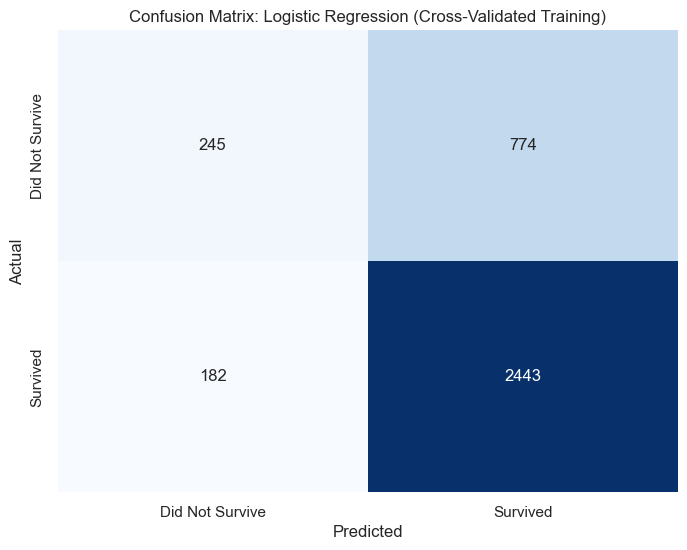

/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

Classification Report - Logistic Regression (Test Set)
              precision    recall  f1-score   support

           0       0.63      0.27      0.38       255
           1       0.77      0.94      0.84       656

    accuracy                           0.75       911
   macro avg       0.70      0.60      0.61       911
weighted avg       0.73      0.75      0.71       911

Logistic Regression ROC-AUC Score on Test Set: 0.7512
Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/ROC_Curve_Logistic Regression.png


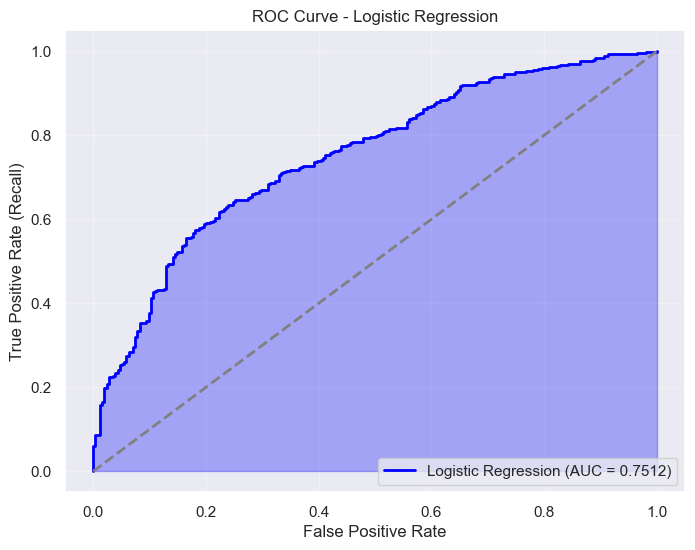

Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Precision_Recall_Curve_Logistic Regression.png


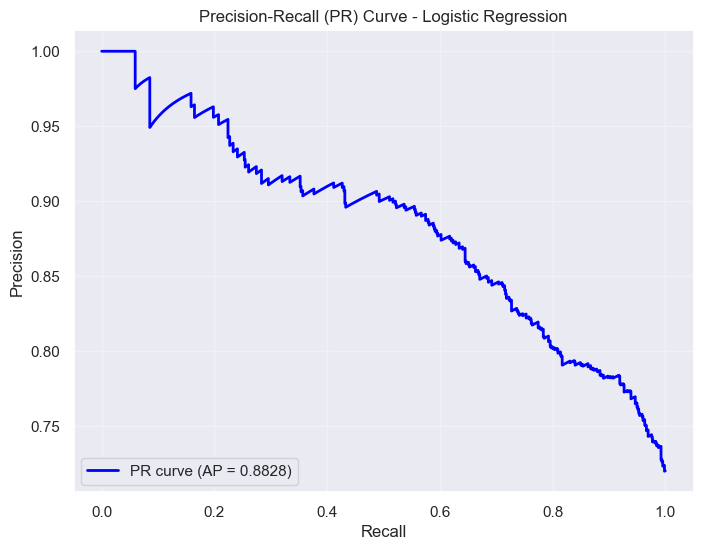


--- Evaluating Random Forest ---


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Random Forest Cross-Validation Accuracy Scores: [0.77640604 0.75171468 0.7558299  0.77091907 0.71428571]
Random Forest Average Cross-Validation Accuracy: 0.7538


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Confusion_Matrix_Random Forest_Cross_Validated_Training.png


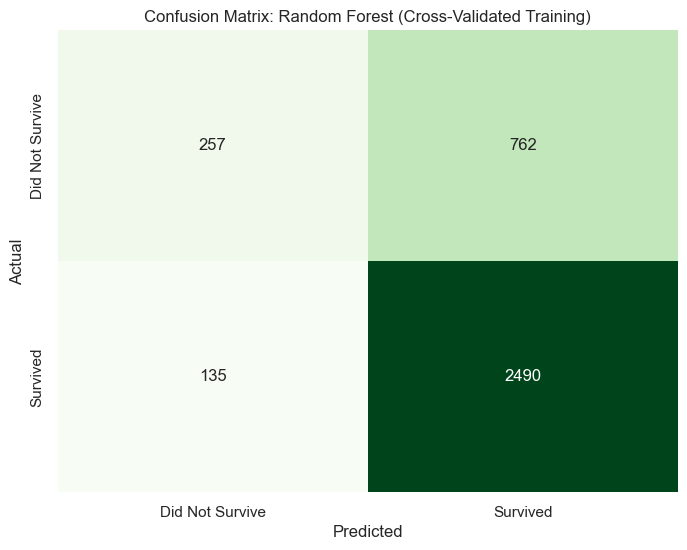

/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Report - Random Forest (Test Set)
              precision    recall  f1-score   support

           0       0.72      0.29      0.41       255
           1       0.78      0.96      0.86       656

    accuracy                           0.77       911
   macro avg       0.75      0.62      0.63       911
weighted avg       0.76      0.77      0.73       911

Random Forest ROC-AUC Score on Test Set: 0.7684
Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/ROC_Curve_Random Forest.png


/Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/dragonFunctions.py:446: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='grey', lw=2)  # Diagonal line


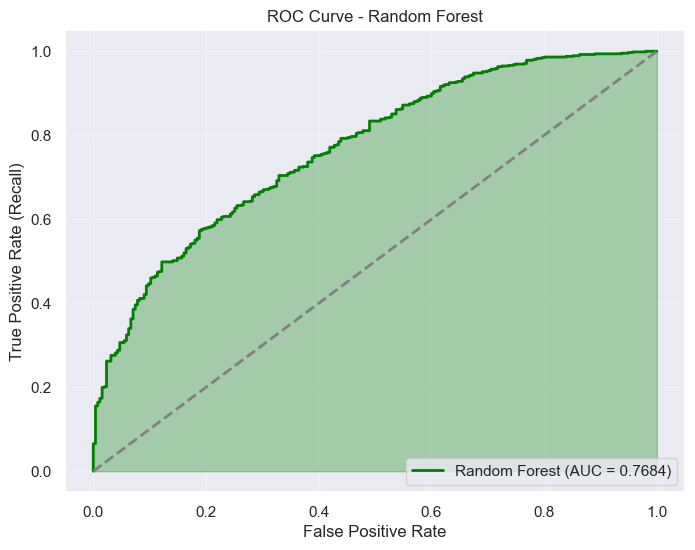

Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Precision_Recall_Curve_Random Forest.png


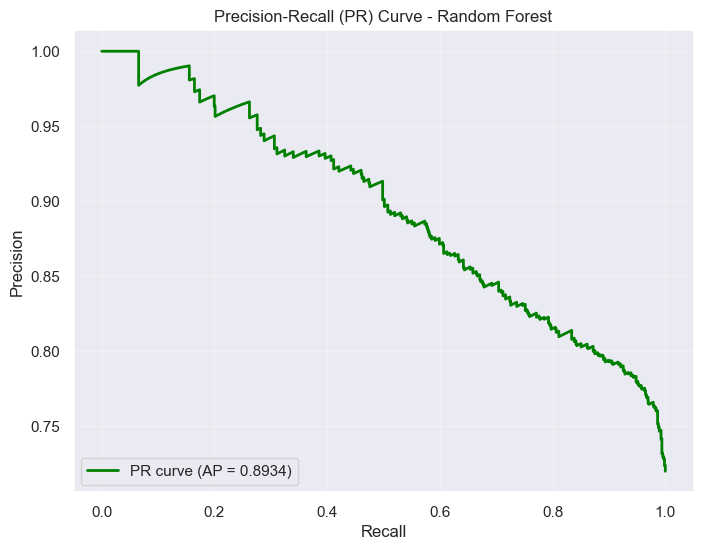


--- Evaluating XGBoost ---


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/co

XGBoost Cross-Validation Accuracy Scores: [0.76954733 0.74622771 0.75720165 0.75857339 0.71428571]
XGBoost Average Cross-Validation Accuracy: 0.7492


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/co

Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Confusion_Matrix_XGBoost_Cross_Validated_Training.png


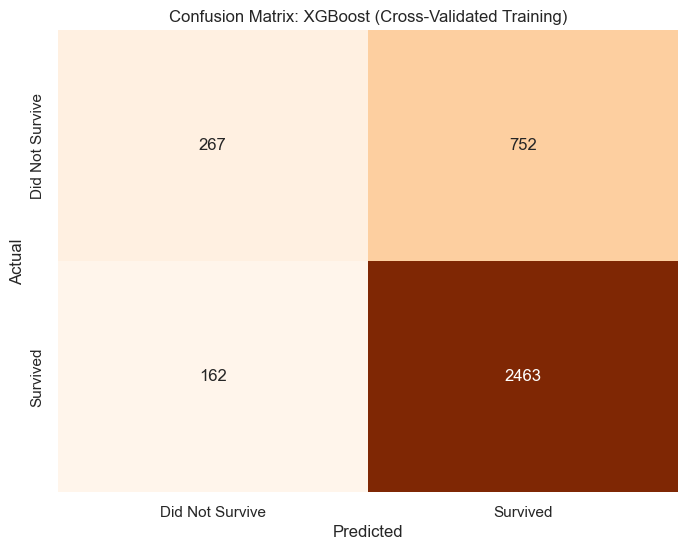

/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/co

Classification Report - XGBoost (Test Set)
              precision    recall  f1-score   support

           0       0.68      0.31      0.42       255
           1       0.78      0.94      0.85       656

    accuracy                           0.77       911
   macro avg       0.73      0.63      0.64       911
weighted avg       0.75      0.77      0.73       911

XGBoost ROC-AUC Score on Test Set: 0.7828
Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/ROC_Curve_XGBoost.png


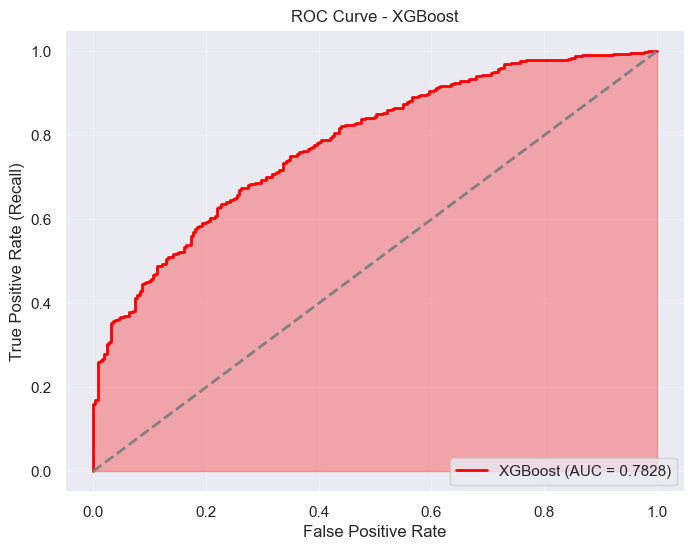

Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Precision_Recall_Curve_XGBoost.png


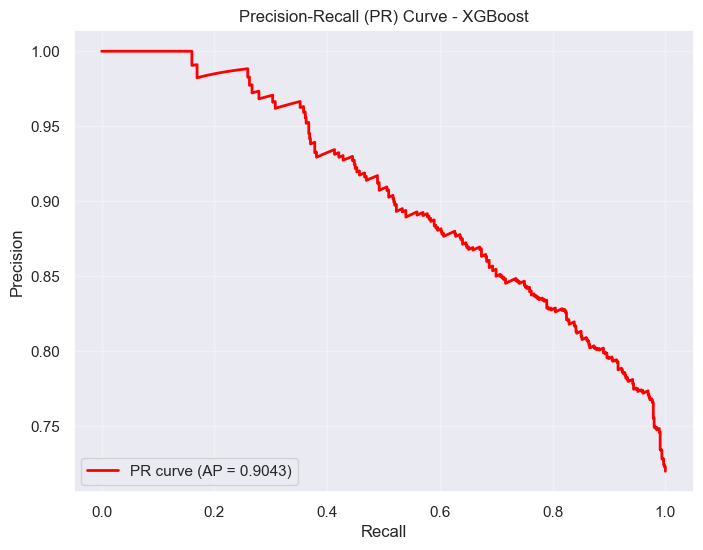

In [67]:
# Initialize a dictionary to store metrics and predicted probabilities for each model
model_metrics = {}

# Define the directories
data_directory = Path('FILES') / 'Data'  # Directory for CSVs
plot_directory = Path('REPORT') / 'Report Figures' / 'Plots'  # Directory for Plots

# Create directories if they don't exist
data_directory.mkdir(parents=True, exist_ok=True)
plot_directory.mkdir(parents=True, exist_ok=True)

calibrated_lr_metrics = evaluate_model(
    model= calibrated_log_reg,
    model_name='Logistic Regression',
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    color=model_colors['Logistic Regression'],
    data_directory=data_directory,
    plot_directory=plot_directory,
    kf=kf  # Passed kf as an argument
)
model_metrics['Logistic Regression Calibrated'] = calibrated_lr_metrics

# Evaluate Random Forest
calibrated_rf_metrics = evaluate_model(
    model=calibrated_rf,
    model_name='Random Forest',
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    color=model_colors['Random Forest'],
    data_directory=data_directory,
    plot_directory=plot_directory,
    kf=kf  # Passed kf as an argument
)
model_metrics['Random Forest Calibrated'] = calibrated_rf_metrics

# Evaluate XGBoost with Specified Hyperparameters
calibrated_xgb_metrics = evaluate_model(
    model= calibrated_xgb,
    model_name='XGBoost',
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    color=model_colors['XGBoost'],
    data_directory=data_directory,
    plot_directory=plot_directory,
    kf=kf  # Passed kf as an argument
)
model_metrics['XGBoost Calibrated'] = calibrated_xgb_metrics

/Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/dragonFunctions.py:517: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='grey', lw=2)


Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Combined_ROC_Curves.png


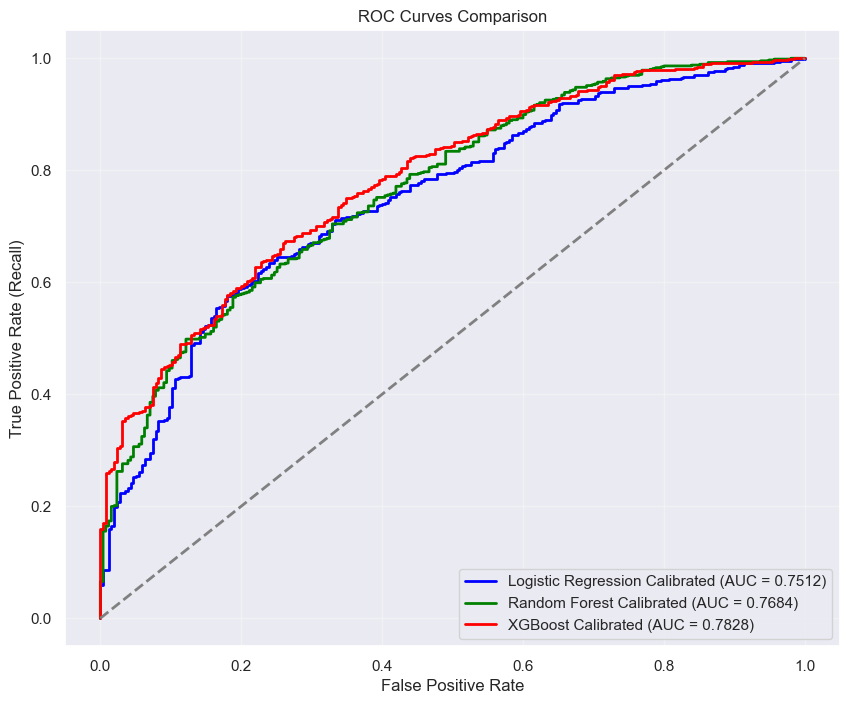

Combined ROC Curves plot saved at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Combined_ROC_Curves.png


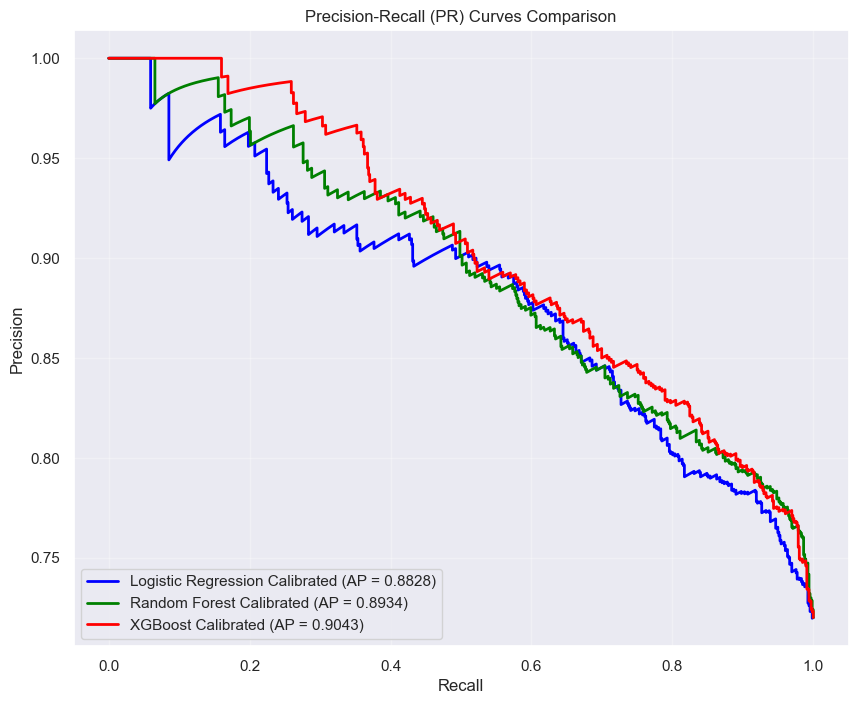

Plot saved successfully at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Combined_Precision_Recall_Curves.png
Combined Precision-Recall Curves plot saved at /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Code/REPORT/Report Figures/Plots/Combined_Precision_Recall_Curves.png


In [68]:
model_colors = {
    'Logistic Regression Calibrated': 'blue',
    'Random Forest Calibrated': 'green',
    'XGBoost Calibrated': 'red'
}

# Plot and save combined ROC curves
plot_combined_roc(model_metrics, plot_directory, model_colors)

# Plot and save combined Precision-Recall curves
plot_combined_pr(model_metrics, plot_directory, model_colors)

/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/josh/anaconda3/lib/python3.11/site-packages/xgboost/co

Model calibrated using sigmoid method.


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model calibrated using sigmoid method.


/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

Model calibrated using sigmoid method.


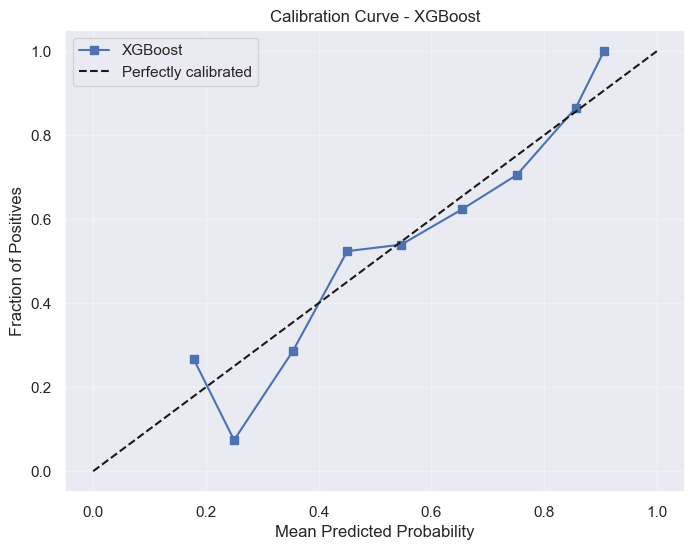

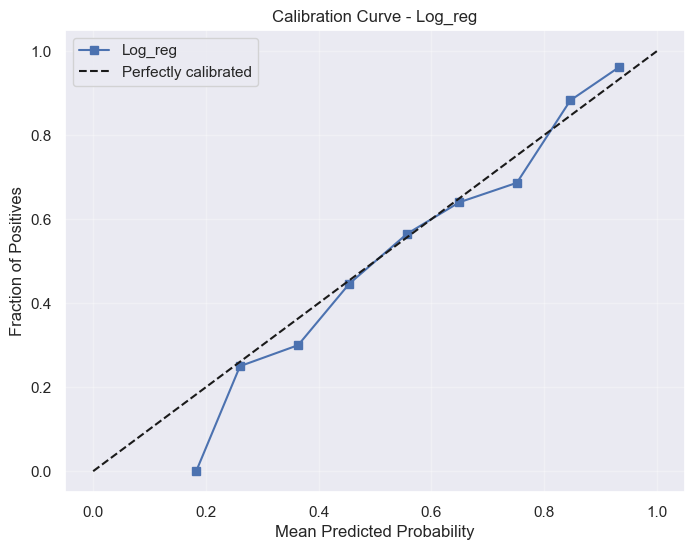

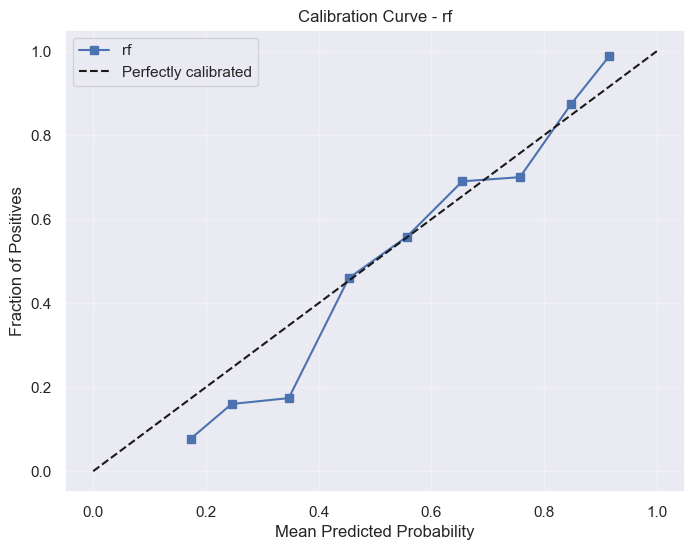

In [69]:
calibrated_xgb = calibrate_model(best_xgb, X_train, y_train)
calibrated_rf = calibrate_model(rf, X_train, y_train)
calibrated_log_reg = calibrate_model(log_reg, X_train, y_train)

plot_calibration_curve(calibrated_xgb, X_test, y_test, "XGBoost")
plot_calibration_curve(calibrated_log_reg, X_test, y_test, "Log_reg")
plot_calibration_curve(calibrated_rf, X_test, y_test, "rf")

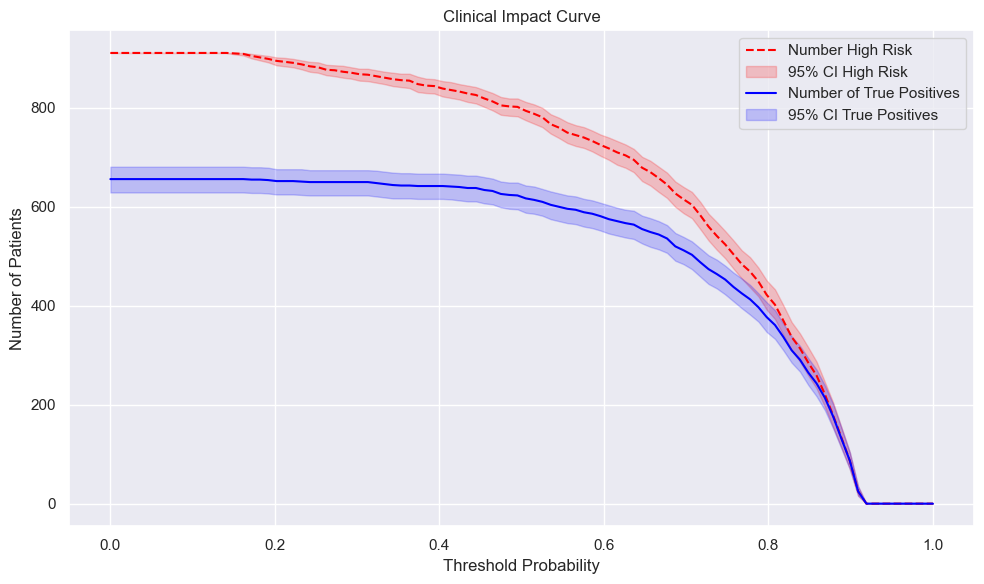

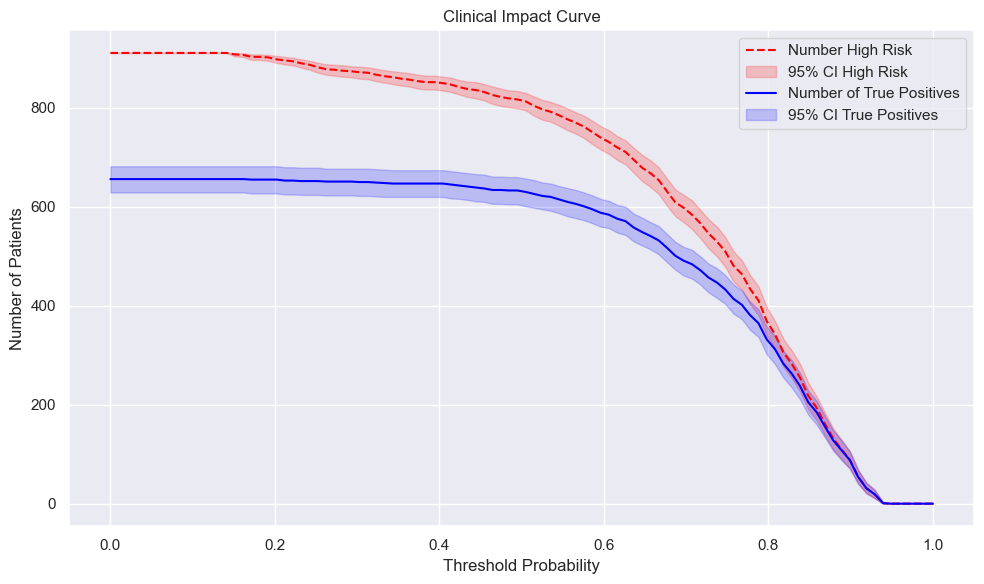

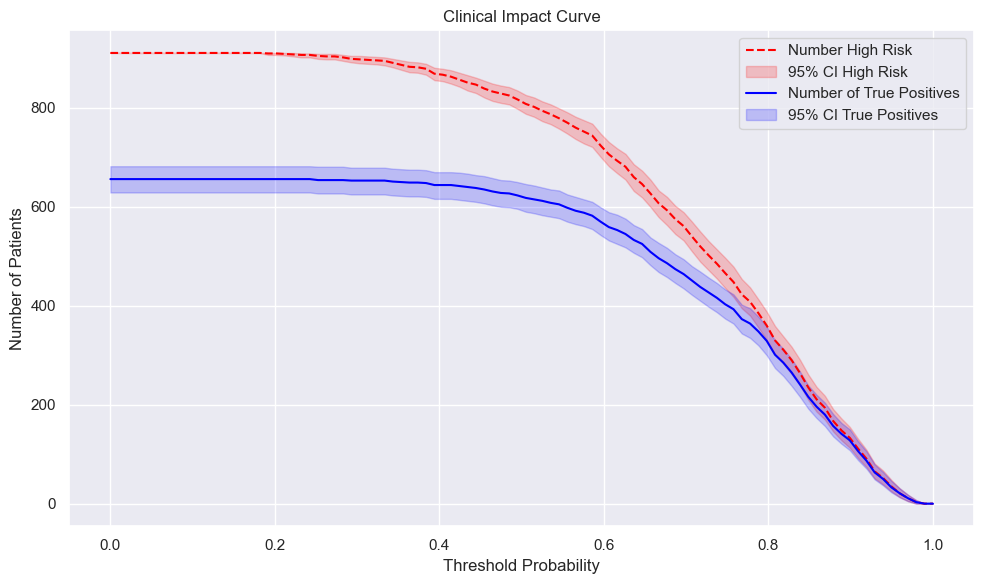

In [70]:
plot_clinical_impact_curve(calibrated_xgb, X_test, y_test)
plot_clinical_impact_curve(calibrated_rf, X_test, y_test)
plot_clinical_impact_curve(calibrated_log_reg, X_test, y_test)

In [71]:
from statkit.non_parametric import bootstrap_score
from statkit.decision import NetBenefitDisplay
y_prob_log_reg = calibrated_log_reg.predict_proba(X_test)[:, 1]
auc_95ci = bootstrap_score(y_test, y_prob_log_reg, metric=roc_auc_score)
print('Area under the ROC curve:', auc_95ci)

y_prob_xgb = calibrated_xgb.predict_proba(X_test)[:, 1]
auc_95ci = bootstrap_score(y_test, y_prob_xgb, metric=roc_auc_score)
print('XGB Model: Area under the ROC curve:', auc_95ci)

y_prob_rf = calibrated_rf.predict_proba(X_test)[:, 1]
auc_95ci = bootstrap_score(y_test, y_prob_rf, metric=roc_auc_score)
print('RF Model: Area under the ROC curve:', auc_95ci)

Area under the ROC curve: 0.75 (95 % CI: 0.72-0.78)
XGB Model: Area under the ROC curve: 0.79 (95 % CI: 0.75-0.82)
RF Model: Area under the ROC curve: 0.77 (95 % CI: 0.73-0.80)


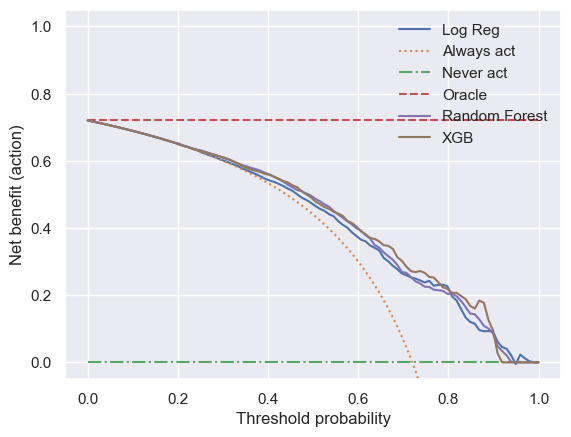

In [72]:
y_pred_base = calibrated_log_reg.predict_proba(X_test)[:, 1]
y_pred_xgb = calibrated_xgb.predict_proba(X_test)[:, 1]
y_pred_tree = calibrated_rf.predict_proba(X_test)[:, 1]

NetBenefitDisplay.from_predictions(y_test, y_pred_base, name='Log Reg')
NetBenefitDisplay.from_predictions(y_test, y_pred_tree, name='Random Forest', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test,y_pred_xgb, name='XGB', show_references=False, ax=plt.gca())